Created on Monday 11 January 2021

Group 5 - Classification

@authors : F.B

In [ ]:
!python3 -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6MB 1.1MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=159c4d469a8f261939a5f3aae7acbd3de7a353c8462437829d3b1c291858727b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4g2iq5ja/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/G5 Inter-Promo 2021/Données/Input")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.setrecursionlimit(10000)

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA

from nltk.stem import  WordNetLemmatizer
lemmer=WordNetLemmatizer()
import nltk
nltk.download('wordnet')
from textblob import TextBlob
import spacy
import fr_core_news_md
nlp = fr_core_news_md.load()

from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
bow = pd.read_csv("BOW.csv")
bow.head()

,000,01,02,03,04,06,07,08,09,10,100,1000,11,110,118,11h,12,120,13,14,15,150,1500,16,17,18,180,19,1997,1998,1999,1er,20,200,2000,2001,2002,2003,2004,2005,...,étendue,éthique,étions,étranger,étrangers,étrangères,étroite,étroitement,étude,études,étudiant,étudiants,étudier,été,évaluation,évaluer,évalué,éventuellement,éventuelles,évidemment,évidence,évident,éviter,évolue,évoluent,évoluer,évolutif,évolution,évolutions,évolué,évoque,évoquer,évoqué,événement,événements,êtes,être,île,œuvre,art_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [ ]:
# this function allows you to lemmatize English words

def lemmatization(word : str) -> str:
  """
  parameters
    word : word to lemmatize
  Output
    word : lemmatized word
  """
  for pos in ['a', 's', 'r', 'n', 'v']:
    word=lemmer.lemmatize(word, pos)
  return word

In [ ]:
# This function allows you to clean up keywords

def clean_keyword(link_keyword : str, bow : pd.DataFrame = bow) -> list:
  """
  Parameters :
      link_keyword : link of keyword
      bow : bow dataframe 
    Output : 
      list_key_word : list of cleaned keywords 
  """

  df_lexique: pd.DataFrame = pd.read_csv(link_keyword, sep="  ", header=None)
  df_lexique.columns: list = ['key_word']
  list_key_word = df_lexique.key_word.values.tolist()
  list_key_word_need : list = []

  columns_bow = bow.columns
  stop_word =[ 'le', 'par', 'les', 'du', 'la', 'de']

  #
  for key in list_key_word :
    for k in key.split():
      if k in columns_bow and k not in stop_word:
        list_key_word_need.append(k)

    #
    blob = TextBlob(key)
    try :
      if blob.detect_language()=='fr':
        k_npl=nlp(key)
        for j in k_npl:
          jj = j.lemma_
          if jj in columns_bow and k not in stop_word:
            list_key_word_need.append(jj)
      elif blob.detect_language()=='en' :
        for k in key.split():
          kk = lemmatization(k)
          if kk in columns_bow and k not in stop_word:
            list_key_word_need.append(kk)
    except :
      pass 



  list_key_word_need = pd.unique(list_key_word_need).tolist()
  return list_key_word_need

link_keyword = "/content/drive/MyDrive/G5 Inter-Promo 2021/Ressources/Lexique_Innovation.txt"
list_key_word_need = clean_keyword(link_keyword)
list_key_word_need [ : 5]

['innovation', 'automatique', 'ingénierie', 'modèles', 'ligne']

In [ ]:
data = bow[list_key_word_need]

# Classification

In [ ]:
data.describe()

,innovation,automatique,ingénierie,modèles,ligne,produits,traçabilité,recherche,opérationnelle,machine,learning,intelligence,artificielle,traitement,langage,analyse,3d,données,réalité,augmentée,virtuelle,mixte,sociale,réseau,sécurité,si,systèmes,algorithmes,base,data,design,reconnaissance,big,numérique,digital,cloud,ai,connaissances,interface,smart,city,ville,université,futur,industrie,optimisation,système,recommandation,moteur,web,développement,durable,écologie,résilience,interfaces,digitalisation,saas,déploiement,fusion,aide,décision,code,véhicule,autonome,it,conjoncture,enjeux,prospective,nouvelle,génération
count,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.00000,12261.000000,12261.000000,12261.000000,12261.00000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.00000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000
mean,0.534214,0.028627,0.017698,0.074953,0.338064,0.284642,0.038985,0.806296,0.038007,0.034744,0.032950,0.096893,0.085066,0.333496,0.015578,0.136938,0.071772,0.930430,0.140445,0.017046,0.017617,0.031971,0.289781,0.207324,0.635266,1.065248,0.178370,0.018922,0.190523,0.121931,0.046000,0.074872,0.052198,0.400049,0.103173,0.259685,0.465460,0.060762,0.014436,0.059375,0.036620,0.353071,0.094201,0.086127,0.196803,0.028220,0.390833,0.03711,0.036294,0.734850,0.761112,0.21132,0.028954,0.017127,0.012315,0.085882,0.060762,0.172580,0.081641,0.216051,0.192970,0.144279,0.022347,0.018922,0.02406,0.016067,0.545306,0.033521,0.625316,0.089063
std,2.539972,0.211217,0.202585,0.375875,1.101672,1.114366,0.580077,3.908465,0.254533,0.359354,0.382177,0.842048,0.783719,1.275933,0.161565,0.539703,0.529616,2.776969,0.579852,0.219267,0.236235,0.255999,1.419952,0.881798,3.346895,2.387430,0.759116,0.185882,0.635732,0.796542,0.825968,0.404831,0.509341,1.769986,0.579453,1.575898,2.066209,0.379290,0.141780,0.537863,0.402131,1.697579,0.986458,0.411008,1.186249,0.219416,1.319113,0.37544,0.238410,3.282126,2.126069,1.03035,0.257786,0.209171,0.129983,0.476064,0.456039,0.707615,0.663010,0.896735,0.611302,0.728905,0.297334,0.181441,0.30732,0.202318,1.335550,0.241195,1.297466,0.575233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [ ]:
# Centre and reduce
data_scale = scaler.fit_transform(data)

In [ ]:
# generate the link matrix
Z = linkage(data_scale, method='ward', metric='euclidean')

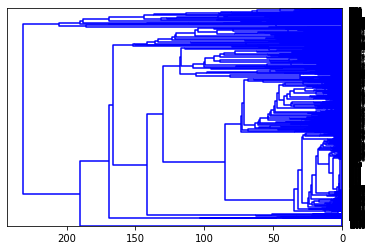

In [ ]:
# dendrogram display
dendrogram(Z, orientation='left', color_threshold=0)
plt.show()

In [ ]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
#use of "silhouette" metrics


#Vary the number of clusters from 2 to 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
  km = cluster.KMeans(n_clusters=k+2)
  km.fit(data)
  res[k] = metrics.silhouette_score(data,km.labels_)
res[:3]

array([0.69421471, 0.57944592, 0.59714558])

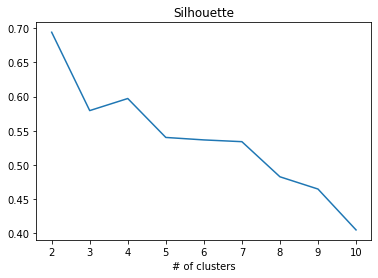

In [ ]:
#graphic

plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

In [ ]:
# The partition in k = 2 groups seems to be the better in the sense of the metric "silhouette". 

# Labelling

In [ ]:
data ['label_innovation'] = kmeans.labels_

In [ ]:
# Detecting the class of non-innovative documents 
count_keyword = np.sum(data[list_key_word_need].T).tolist()
data ['count_keyword'] = count_keyword



# the class of non-innovative items
dff = data[data['count_keyword']==0]
pd.unique(dff.label_innovation.values)

array([1], dtype=int32)

In [ ]:
# Assign 1 to the class of innovative items and 0 otherwise
data['label_innovation'].replace(1,-1, inplace=True)
data['label_innovation'].replace(0,1, inplace=True)
data['label_innovation'].replace(-1,0, inplace=True)

In [ ]:
# 
data.drop('count_keyword', axis=1, inplace=True)

In [ ]:
# 
def training(model, if_plot : bool = False, if_val_cross = False) :
  """
  Parameters : 
            model : model
            if_plot :
            if_val_cross :
  Output :
  """
  #
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))
    
  #
  else :
    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No innovation', 'Innovation']);


logit
accuracy ...
0.9986409350366947
f1_score ...
0.959349593495935
----------------------------------------------------
rf
accuracy ...
0.9980973090513726
f1_score ...
0.9401709401709402
----------------------------------------------------
lgbm
accuracy ...
0.9980973090513726
f1_score ...
0.9421487603305784
----------------------------------------------------


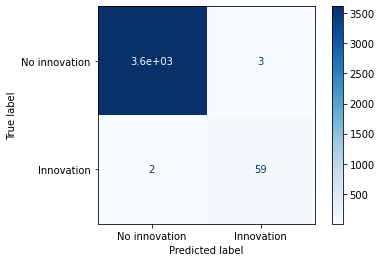

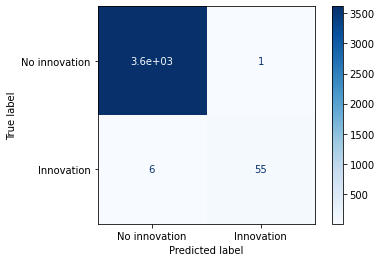

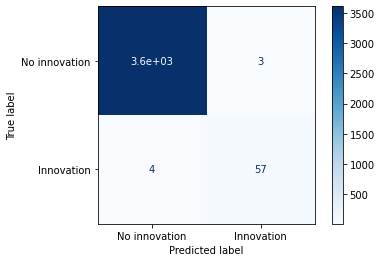

In [ ]:
X = data.drop('label_innovation', axis=1).values
y = data.label_innovation.values

models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier(),
    'lgbm': LGBMClassifier()
}


for model in models.keys():
  print(model)
  training(models[model], True)
  print('----------------------------------------------------')

In [ ]:
for model in models.keys():
  print(model)
  training(models[model], False, True)
  print('----------------------------------------------------')

logit
accuracy ...
[0.99184672 1.         1.         0.99632953 1.        ]
f1_score ...
[0.84375    1.         1.         0.91588785 1.        ]
----------------------------------------------------
rf
accuracy ...
[0.98899307 0.99673736 0.99755302 0.9959217  0.99632953]
f1_score ...
[0.8        0.91836735 0.97087379 0.88888889 0.90721649]
----------------------------------------------------
lgbm
accuracy ...
[0.98654709 0.99959217 1.         0.9959217  0.99755302]
f1_score ...
[0.76258993 0.99047619 1.         0.9        0.94      ]
----------------------------------------------------


# Output

In [ ]:
print('The number of relevant documents :',len(y[y==1]))

The number of relevant documents : 266


In [ ]:
label = pd.DataFrame(bow.art_id.tolist() , columns=['art_id'])
label ['label_innovation'] = y
label.head()

,art_id,label_innovation
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
#label.to_csv('../Output/label_innovation_unsupervised_bow.csv', index=False)